# Machine Learning process

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import glob
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Load data

In [45]:
##       TEST 1:
## Selecting a CSV for train and another CSV to test

# df_train = pd.read_csv('./filtered_data/smartphone_02-Feb-2022-20-22_cambio de línea agresivo izquierda_Data-Mv2MN6xv2W3Rv1Rmb_Z.csv')
# df_test = pd.read_csv('./filtered_data/smartphone_02-Feb-2022-20-19_cambio de línea agresivo izquierda_Data-Mv2L_EBJR_gDU3LpwVs.csv')

##       TEST 2:
## Joining all CSVs of a particular event

device = 'smartphone'
event = 'frenada repentina'
files_to_read = glob.glob('./filtered_data/{}*{}*.csv'.format(device, event))

df = pd.DataFrame()
i = 0
for file in files_to_read[:]:
    i += 1
    df = pd.concat([df, pd.read_csv(file)])

print("files count: ", i)
df_validation = pd.read_csv(files_to_read[:1][0]) # './filtered_data/smartphone_02-Feb-2022-20-33_conducción por ipiales_Data-Mv2OkQ_MG7IB4QX-XVx.csv')
##       TEST 2-1:
## Spliting the TEST 2 dataframe in train and test

# df_train, df_test = train_test_split(df, test_size=0.3, train_size=0.7, random_state=0, shuffle=False)
# print("Train data size: ", df_train.shape)
# print("Near crash event train data size: ", df_train["eventClass"][df_train["eventClass"] == 1].shape)
# print("No near crash event train data size: ", df_train["eventClass"][df_train["eventClass"] == 0].shape)

# print("\nTest data size: ", df_test.shape)
# print("Near crash event test data size: ", df_test["eventClass"][df_test["eventClass"] == 1].shape)
# print("No near crash event test data size: ", df_test["eventClass"][df_test["eventClass"] == 0].shape)

##      TEST 2-2:
## Don't split the TEST 2 dataframe!

print("All data size: ", df.shape)
print("Near crash event data size: ", df["eventClass"][df["eventClass"] == 1].shape)
print("No near crash event data size: ", df["eventClass"][df["eventClass"] == 0].shape)

# Show dataframe
df.head(4)

files count:  8
All data size:  (3893, 18)
Near crash event data size:  (371,)
No near crash event data size:  (3522,)


,id,accX,accY,accZ,eventClass,idTrip,idVehicle,latitude,longitude,magX,magY,magZ,route,speed,timestamp,velAngX,velAngY,velAngZ
0,32845,0.346099,0.070198,9.624315,0,7,Nissan March (Xiaomi Redmi Note 9S),0.834003,-77.650027,0.284063,0.182334,0.906758,Frenada repentina,11.969349,2022-02-02 20:01:54.474000-05:00,0.003772,0.008679,0.004936
1,32846,0.332630,0.228663,9.626677,0,7,Nissan March (Xiaomi Redmi Note 9S),0.834003,-77.650027,0.283059,0.178624,0.908543,Frenada repentina,11.969349,2022-02-02 20:01:54.523000-05:00,0.004849,0.008580,0.004002
2,32847,0.347030,0.102652,9.635826,0,7,Nissan March (Xiaomi Redmi Note 9S),0.834003,-77.650027,0.303128,0.233605,0.881443,Frenada repentina,11.969349,2022-02-02 20:01:54.573000-05:00,0.002411,0.009508,0.001526
3,32848,0.339322,0.322767,9.615295,0,7,Nissan March (Xiaomi Redmi Note 9S),0.834003,-77.650027,0.306454,0.246007,0.875449,Frenada repentina,11.969349,2022-02-02 20:01:54.623000-05:00,0.004636,0.009561,0.000243


### Select the interest variables

In [46]:
# total_features = ["speed","accX","accY","magX","magY","magZ", "velAngX","velAngY","velAngZ","timestamp","eventClass"]
event_features = ["speed","accY"] # Agresive Acceleration and Agresive Brake (only smartphone)
#event_features = ["speed", "accPosition", "accY"] # Agresive Acceleration (only raspberry)
#event_features = ["speed", "accY"] # Agresive Brake (only raspberry)
#event_features = ["accX", ,"accY", "velAngZ", "magX", "magY"] # Agresive turn right and left  (only smartphone)
#event_features = ["speed", "accX", "accY", "velAngZ", "magX"] # Agresive turn right and left  (only raspberry)
#event_features = ["accX", "velAngZ"] # Change line right and left (smartphone and raspberry)

# Always put "eventClass" at the end:
event_features_label = ["id", *event_features,  "eventClass"]
dataset = df[event_features_label].to_numpy()
dataset_validation = df_validation[event_features_label].to_numpy()
print("All data shape for the selected features: ",dataset.shape)

##    TEST 1 or 2-1
## Run the following code for the mentioned TEST
## Don't run in the TEST 2-2

# dataset_train = df_train[event_features_label].to_numpy()
# print("Shape of training data for the selected features: ", dataset_train.shape)

# dataset_test = df_test[event_features_label].to_numpy()
# print("Shape of testing data for the selected features: ", dataset_test.shape)

All data shape for the selected features:  (3893, 4)


### Make a sliding window

The sliding window have this shape:

$ rows = m - ws + 1 \\  columns = ws \\ pages = d$

![](https://es.mathworks.com/help/matlab/math/nddemo_02_es.gif)

Where:
- ***m***:  Is the dataset rows number
- ***ws***: Is the window size
- ***d***:  Is the number of feature of the data


#### Naive alternative
Sliding window without frames

In [32]:
def sliding_windows(dataset, window_size=20, event_features="X"):
    """Create a sliding window with a defined window size and return the calculation for each record inside the sliding window.

    The calculations made are for each time window: 
    - The mean.
    - The median.
    - The standard deviation.
    - The maximum and minimum value.
    - The trend.

    Note the process is explained in greater detail in: <TODO: reference link>

    Args:
        dataset (numpy.array): An array with the data taken on a vehicle trip, 
        composed for rows: dataset registers and columns: first data index, and subsequent dataset event features.
        window_size (int, optional): number Number of registers contained in the time window. Defaults to 10.
        event_features (str, optional): _description_. Defaults to "X".

    Returns:
        tuple: A tuple structured like this: (sliding window id, sliding window featured data, sliding window label data, features name)
    """
    sld_window = np.lib.stride_tricks.sliding_window_view(dataset, window_size, axis=0) #[::1, :] Add this for define window step
    print("\nSliding windows shape: ",sld_window.shape)

    # Splitin dataset id
    id = sld_window[:,0:1,:]
    sld_window_id = np.concatenate((id[:,:,0], id[:,:,-1]), axis=1) # get the first and last id from registers

    # Spliting the dataset (features, label)
    separator = dataset.shape[1] - 1 # Split the last page corresponding to the eventClass
    features_data = sld_window[:, 1:separator, :]
    label_data = sld_window[:, separator, :]

    # Processing the sliding window
    # Get the mean, median, std, max and min value
    mean = features_data.mean(axis=2)
    median = np.median(features_data, axis=2)
    std = features_data.std(axis=2)
    max_val = features_data.max(axis=2)
    min_val = features_data.min(axis=2)
    # Get tendency
    divider = np.array([mean[0], *mean[:-1]])
    tendency = mean/np.where(divider == 0, 1, divider)
    label = st.mode(label_data, axis=1)[0]

    # Concatenate processed sliding window
    sld_window_features = np.concatenate((mean, median, std, max_val, min_val, tendency), axis=1)
    # Reshape label for sklearn standard
    label = label.reshape(label.shape[0])

    # Make the features names
    e_n = len(event_features) # Events number
    measurements_names = [["mean"]*e_n, ["median"]*e_n, ["std"]*e_n, ["max_val"]*e_n, ["min_val"]*e_n, ["tendency"]*e_n]
    measurements_names = list(itertools.chain(*measurements_names))
    events_names = event_features*(len(measurements_names)//e_n)
    sld_window_features_names = list(map('_'.join, zip(measurements_names, events_names)))

    return (sld_window_id, sld_window_features, label, sld_window_features_names)


In [47]:
window_size = 40

##    TEST 1, 2-1

# X_train, y_train = sliding_windows(variables_train, window_size)
# X_test, y_test = sliding_windows(variables_test, window_size)

##    TEST 2-2

ids, X, y, features_names = sliding_windows(dataset, window_size, event_features)
ids_validation, X_validation, y_validation, features_names_v = sliding_windows(dataset_validation, window_size, event_features)


Sliding windows shape:  (3854, 4, 40)

Sliding windows shape:  (414, 4, 40)


#### Set features dataframe

In [48]:
print("Features shape:", X.shape)
print("\nFeatures size for near crash event: ", np.where(y == 1)[0].shape)
print("Features size for no near crash event: ", np.where(y == 0)[0].shape)
print("\nSample of features: ")
X_df = pd.DataFrame(X, columns=features_names)
X_df[["first","last"]] = ids
X_df.set_index(["first","last"], inplace=True)

X_validation_df = pd.DataFrame(X_validation, columns=features_names_v)
X_validation_df[["first","last"]] = ids_validation
X_validation_df.set_index(["first","last"], inplace=True)

X_df

Features shape: (3854, 12)

Features size for near crash event:  (346,)
Features size for no near crash event:  (3508,)

Sample of features: 


,,mean_speed,mean_accY,median_speed,median_accY,std_speed,std_accY,max_val_speed,max_val_accY,min_val_speed,min_val_accY,tendency_speed,tendency_accY
first,last,,,,,,,,,,,,
32845.0,32884.0,11.969349,0.518429,11.969349,0.218791,0.000000,0.761221,11.969349,2.071598,11.969349,-0.358329,1.000000,1.000000
32846.0,32885.0,11.969349,0.512241,11.969349,0.218791,0.000000,0.765833,11.969349,2.071598,11.969349,-0.358329,1.000000,0.988062
32847.0,32886.0,11.969349,0.503783,11.969349,0.201681,0.000000,0.770770,11.969349,2.071598,11.969349,-0.358329,1.000000,0.983490
32848.0,32887.0,11.969349,0.498097,11.969349,0.201681,0.000000,0.774538,11.969349,2.071598,11.969349,-0.358329,1.000000,0.988712
32849.0,32888.0,11.969349,0.496390,11.969349,0.201681,0.000000,0.774998,11.969349,2.071598,11.969349,-0.358329,1.000000,0.996574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004.0,6043.0,7.281117,0.303022,3.054336,0.271067,6.372486,0.508234,15.022628,1.333574,1.652996,-0.392428,0.964988,0.944310
6005.0,6044.0,7.016943,0.297642,3.054336,0.271067,6.264192,0.501815,15.022628,1.333574,1.652996,-0.392428,0.963718,0.982245
6006.0,6045.0,6.752769,0.298060,3.054336,0.271067,6.142641,0.502343,15.022628,1.333574,1.652996,-0.392428,0.962352,1.001406


## Machine Learning 

Make a Machine Learning algorithms with this librarys and this split of data

In [7]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, train_size=0.7, random_state=300, shuffle=True)

print("Train data shape:", X_train.shape)
print("Train label shape:", y_train.shape)
print("Near crash event train data size: ", np.where(y_train == 1)[0].shape)
print("No near crash event train data size: ", np.where(y_train == 0)[0].shape)

print("\nTest data shape:", X_test.shape)
print("Test label shape:", y_test.shape)
print("Near crash event test data size: ", np.where(y_test == 1)[0].shape)
print("No near crash event test data size: ", np.where(y_test == 0)[0].shape)

Train data shape: (2380, 12)
Train label shape: (2380,)
Near crash event train data size:  (219,)
No near crash event train data size:  (2161,)

Test data shape: (1021, 12)
Test label shape: (1021,)
Near crash event test data size:  (101,)
No near crash event test data size:  (920,)


### Support Vector Machines

In [10]:
clf_svm = svm.SVC(C=10, gamma=1, kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)

SVC(C=10, gamma=1, probability=True)

### Decision Trees

9 38


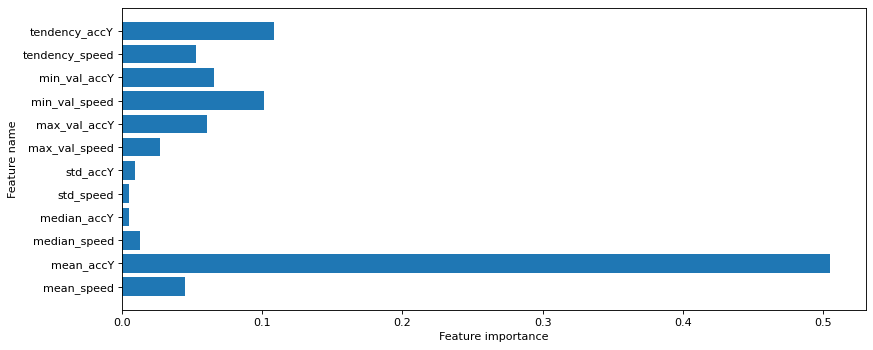

In [11]:
clf_dt = tree.DecisionTreeClassifier(criterion = "gini")
clf_dt.fit(X_train, y_train)

print(clf_dt.get_depth(), clf_dt.get_n_leaves())

# Check more significants variables
def plot_feature_importances(clf, features_names):
    c_features = len(features_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), features_names)

plt.figure(figsize=(12,5), dpi=80)
plot_feature_importances(clf_dt, features_names)
plt.show()

#### Decision tree representation

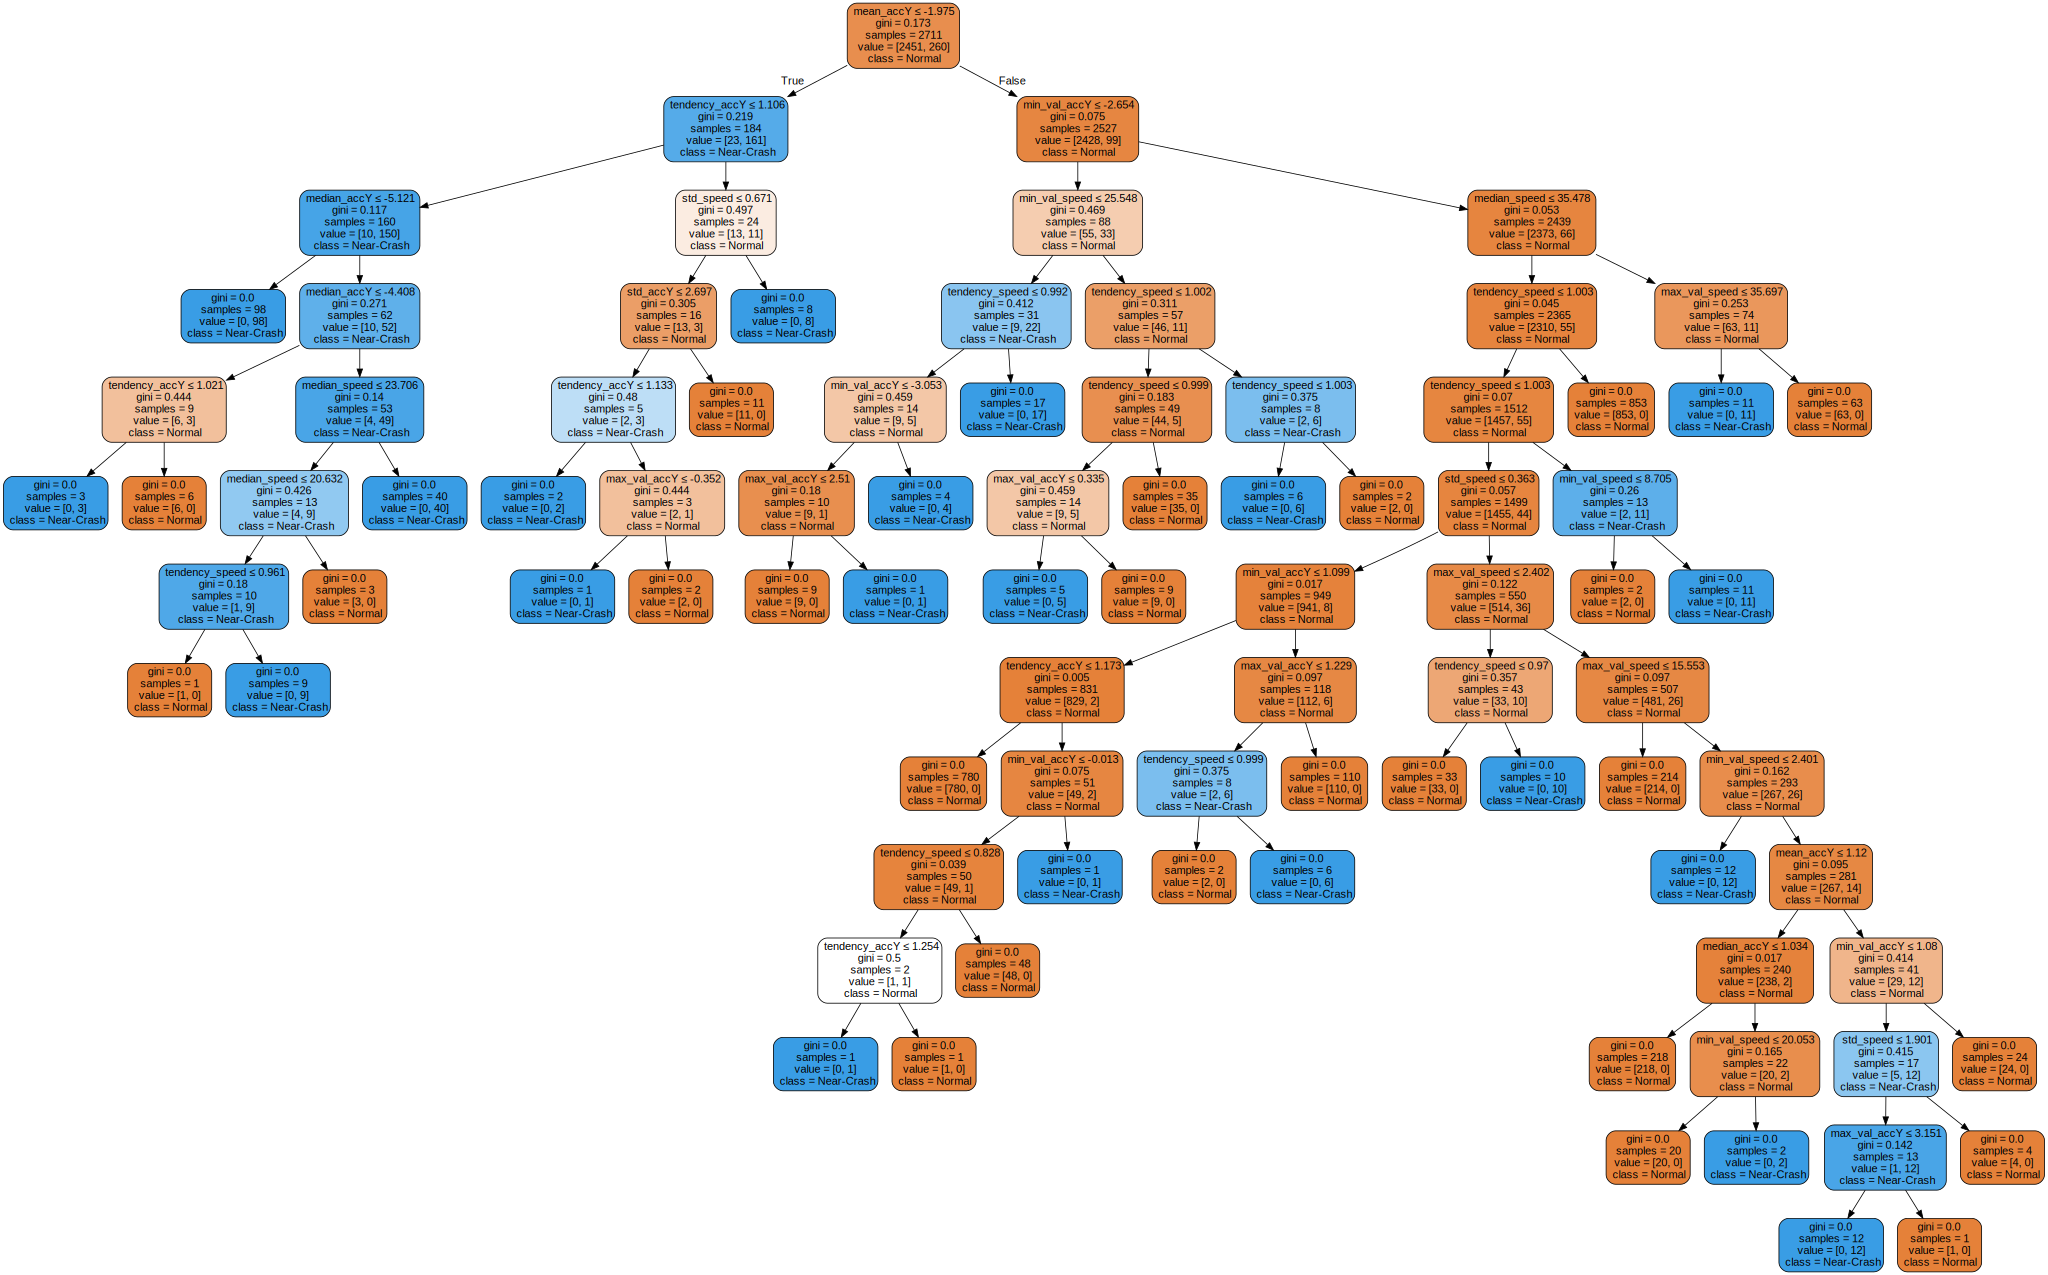

In [95]:
import graphviz
dot_data = tree.export_graphviz(clf_dt, out_file=None, 
                                feature_names=features_names,
                                class_names=["Normal", "Near-Crash"],
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data)
graph

### Random forest

In [49]:
clf_rf = RandomForestClassifier(class_weight=None, max_samples= None, n_estimators=300)
clf_rf.fit(X_df.values, y)

RandomForestClassifier(n_estimators=300)

### Test ML algorithm

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter
"""
Accuracy = TP + TN / (TP + TN + FP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
F1 = 2 * Precision * Recall / (Precision + Recall)
"""

for clf in (clf_svm, clf_dt, clf_rf):
    y_predict = clf.predict(X_test)
    y_predict_proba = clf.predict_proba(X_test)[:,1]
    print("\nClassifier Name: ",clf.__class__.__name__)

    print('Accuracy: {:.6f}'.format(accuracy_score(y_test, y_predict)))
    print('Precision: {:.6f}'.format(precision_score(y_test, y_predict)))
    print('Recall: {:.6f}'.format(recall_score(y_test, y_predict)))
    print('F1: {:.6f}'.format(f1_score(y_test, y_predict)))
    print('AUC: {:.6f}'.format(roc_auc_score(y_test, y_predict_proba)))
    print("Count total data predicted: Near Crash = {}, Normal = {}".format(Counter(y_predict)[1], Counter(y_predict)[0]))


#y_predict = clf_svm.predict(X)
#print(Counter(y), Counter(y_predict))


Classifier Name:  SVC
Accuracy: 0.975514
Precision: 0.931818
Recall: 0.811881
F1: 0.867725
AUC: 0.996508
Count total data predicted: Near Crash = 88, Normal = 933

Classifier Name:  DecisionTreeClassifier
Accuracy: 0.989226
Precision: 0.950000
Recall: 0.940594
F1: 0.945274
AUC: 0.967580
Count total data predicted: Near Crash = 100, Normal = 921

Classifier Name:  RandomForestClassifier
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1: 1.000000
AUC: 1.000000
Count total data predicted: Near Crash = 101, Normal = 920


#### Confusion matrix


Classifier Name:  SVC


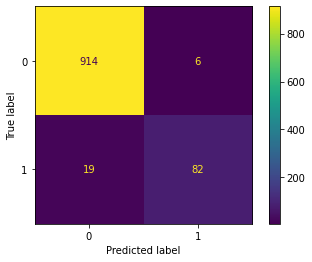


Classifier Name:  DecisionTreeClassifier


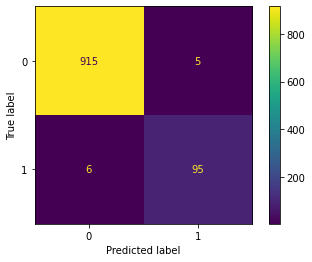


Classifier Name:  RandomForestClassifier


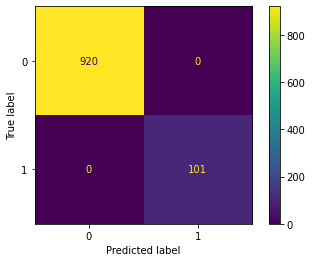

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for clf in (clf_svm, clf_dt, clf_rf):
    print("\nClassifier Name: ",clf.__class__.__name__)
    y_predict = clf.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_predict)
    #print(y_validation, y_predict)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot()
    plt.show()

#### Roc curves and Area Under Curve (AUC)

In [15]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(clf, X_test, y_test):
    clf_name = "".join(c for c in clf.__class__.__name__ if c.isupper())
    y_score = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    #print("Tasa de falsos positivos: {}, Tasa de verdaderos positivos: {}".format(fpr, tpr))
    roc_auc = auc(fpr, tpr)
    accuracy = clf.score(X_test, y_test)
    plt.plot(fpr, tpr, lw=3, alpha=0.7, 
             label='Algorithm {} (acc={:0.6f}, area={:0.6f})'.format(clf_name, accuracy, roc_auc))

Tasa de falsos positivos: [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.47867299e-04
 9.47867299e-04 1.89573460e-03 1.89573460e-03 2.84360190e-03
 2.84360190e-03 3.79146919e-03 3.79146919e-03 5.68720379e-03
 5.68720379e-03 8.53080569e-03 2.18009479e-02 2.18009479e-02
 3.50710900e-02 3.50710900e-02 7.62085308e-01 7.62085308e-01
 9.96208531e-01 1.00000000e+00], Tasa de verdaderos positivos: [0.         0.00925926 0.11111111 0.11111111 0.69444444 0.69444444
 0.73148148 0.73148148 0.7962963  0.7962963  0.9537037  0.9537037
 0.97222222 0.97222222 0.97222222 0.98148148 0.98148148 0.99074074
 0.99074074 1.         1.         1.        ]
Tasa de falsos positivos: [0.         0.00853081 1.        ], Tasa de verdaderos positivos: [0.         0.93518519 1.        ]
Tasa de falsos positivos: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

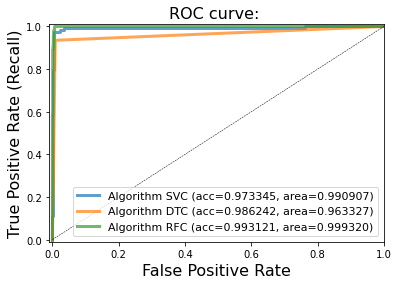

In [16]:
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])

for clf in (clf_svm, clf_dt, clf_rf):
    plot_roc_curve(clf, X_test, y_test)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: ', fontsize=16)
plt.show()

### Optimize algorithms

In [ ]:
print("Parameters SVM: ", clf_svm.get_params())
print("\nParameters DT: ", clf_dt.get_params())
print("\nParameters RF: ", clf_rf.get_params())

In [95]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from scipy.stats import expon as sp_expon
from scipy.stats import randint as sp_randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=160, shuffle=True)
#clf = svm.SVC(kernel='rbf')
#clf = tree.DecisionTreeClassifier(criterion = "gini")
clf = RandomForestClassifier(n_jobs=2)
split = KFold(n_splits=5, shuffle=True, random_state=320)

#grid_values = {'C': [0.01, 0.05, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]} # SVM case
#grid_values = {'max_depth':[2,3,4,5,6,7,8,9,10], 'max_leaf_nodes': [5,6,10,15,20,25,30,40,50,60], 'class_weight': [None, 'balanced']} # DT case
grid_values = {'max_samples':[0.9, 0.95, None], 'n_estimators': [100, 200, 300], 'class_weight': [None, 'balanced']} # RF case

# RandomizedSearchCV alternative
#n_estimators = sp_expon(scale=100)
#max_depth = sp_randint(1, 40)
#param_dist = {
#    "gamma": sp_expon(scale = 10),
#    "C": sp_expon(scale = 10)
#}
scores = ['f1', 'precision', 'recall', 'roc_auc']
for score in scores:
    grid_clf = GridSearchCV(clf, param_grid = grid_values, cv=split,  scoring = score)
    grid_clf.fit(X, y)
    print('\n\nBest parameter (max. {}): {}'.format(score, grid_clf.best_params_))
    print('Best score ({}): {}'.format(score, grid_clf.best_score_))



Best parameter (max. f1): {'class_weight': None, 'max_samples': None, 'n_estimators': 100}
Best score (f1): 0.9844855913222785


Best parameter (max. precision): {'class_weight': 'balanced', 'max_samples': 0.95, 'n_estimators': 100}
Best score (precision): 0.9862532299741602


Best parameter (max. recall): {'class_weight': None, 'max_samples': 0.9, 'n_estimators': 200}
Best score (recall): 0.9826401173577253


Best parameter (max. roc_auc): {'class_weight': None, 'max_samples': None, 'n_estimators': 200}
Best score (roc_auc): 0.9996285541621551


In [99]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit

#clf = svm.SVC(C= 100, gamma= 0.01, kernel='rbf', probability=True) "balanced"
#clf = tree.DecisionTreeClassifier(criterion = "gini", class_weight=None, max_depth=4, max_leaf_nodes=30)
clf = RandomForestClassifier(n_jobs=2, class_weight=None, max_samples=None, n_estimators=200)

cv = KFold(n_splits=5, shuffle=True, random_state=320)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=150)
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=5)  # Make a shuffle split beacuase the data is unbalanced
#cv = StratifiedShuffleSplit(n_splits=5)

#for clf in (clf_svm,clf_dt,clf_rf):
print("\nEstimator: ",clf.__class__.__name__)
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=cv).mean())
print('Cross-validation (F1)', cross_val_score(clf, X, y, cv=cv, scoring = 'f1').mean())
print('Cross-validation (precision)', cross_val_score(clf, X, y, cv=cv, scoring = 'precision').mean())
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=cv, scoring = 'recall').mean())
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=cv, scoring = 'roc_auc').mean())


Estimator:  RandomForestClassifier
Cross-validation (accuracy) 0.9925138312586446
Cross-validation (F1) 0.9800429489556297
Cross-validation (precision) 0.9822093273157103
Cross-validation (recall) 0.9826401173577253
Cross-validation (AUC) 0.9995521693261905


In [33]:
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

y_proba_list = list(zip(y_test[40:100], y_predict[40:100], y_prob[40:100,1] ))
y_proba_list

[(0.0, 0.0, 0.026717715832258224),
 (0.0, 0.0, 0.002811170329213989),
 (0.0, 0.0, 3.5891322203243184e-06),
 (0.0, 0.0, 0.03718512034307072),
 (1.0, 1.0, 0.9932646248554848),
 (0.0, 0.0, 5.880812186837592e-06),
 (0.0, 0.0, 0.0003091054731649595),
 (0.0, 0.0, 1.738266248894623e-07),
 (0.0, 0.0, 0.0028459964447262415),
 (0.0, 0.0, 0.026576680426346314),
 (0.0, 0.0, 8.793170046213386e-05),
 (0.0, 0.0, 0.00021705241929323568),
 (0.0, 0.0, 1.2554277143485653e-05),
 (0.0, 0.0, 0.018475541229286806),
 (0.0, 0.0, 0.011719568486356653),
 (0.0, 0.0, 3.885348770152377e-06),
 (1.0, 1.0, 0.9107705756236444),
 (0.0, 0.0, 0.0002973665039336311),
 (0.0, 0.0, 0.00018371356175025114),
 (0.0, 0.0, 0.001004576819888119),
 (0.0, 0.0, 6.687172909149326e-05),
 (0.0, 0.0, 0.025663145262257932),
 (0.0, 0.0, 0.0007070648946760622),
 (0.0, 0.0, 0.00014912120128252043),
 (0.0, 0.0, 0.0001188681273956779),
 (0.0, 0.0, 0.01104358063083808),
 (1.0, 1.0, 0.9860210426005136),
 (0.0, 0.0, 0.0014146937335905053),
 (0.0, 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict, target_names=['Normal', 'Near Crash']))

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1067
  Near Crash       0.95      0.88      0.91        96

    accuracy                           0.99      1163
   macro avg       0.97      0.94      0.95      1163
weighted avg       0.99      0.99      0.99      1163



[1.00000000e-03 7.74263683e-03 5.99484250e-02 4.64158883e-01
 3.59381366e+00 2.78255940e+01 2.15443469e+02 1.66810054e+03
 1.29154967e+04 1.00000000e+05]


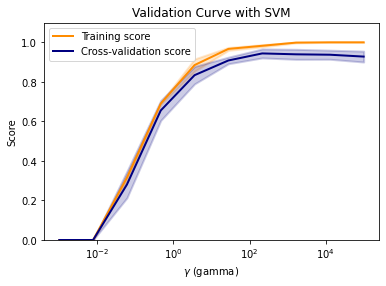

In [21]:
from sklearn.model_selection import validation_curve

#clf_svm = svm.SVC(kernel='rbf', random_state=0)
clf_svm = svm.SVC(gamma=0.02, kernel='rbf', probability=True)
#clf_dt = tree.DecisionTreeClassifier(criterion = "gini", max_depth=None, max_leaf_nodes=None)
param_range = np.logspace(-3, 5, 10)
print(param_range)
train_scores, test_scores = validation_curve(clf_svm, X, y,
                                            param_name='C',
                                            param_range=param_range, cv=cv, scoring = 'recall')
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

#grid_values = [{'gamma': [0.01, 0.05, 0.1, 0.5, 1], 'C': [0.01, 0.05, 0.1, 0.5, 1]},
#               {'gamma': [0.005, 0.01, 0.05, 0.1, 0.5], 'C': [100, 500, 1000, 1500]}, 
#               {'gamma': [0.1, 0.5, 1, 5, 10], 'C': [0.1, 0.5, 1, 5, 10]}]

#

### Generate model

In [50]:
from joblib import dump, load
dump(clf_rf, 'clf_sudden_braking_smartphone.joblib')

['clf_sudden_braking_smartphone.joblib']